## Table of contents

1. [Data overview](#data_overview)    
    1. [Performance of the top classifiers](#performance)
    2. [Finding the best subset](#finding)      
2. [Reconstructing the top models](#reconstructing)    
    1. [ROC curves](#roc_curves)    
6. [Supplementary data](#supplementary)    
    1. [Correlations](#correlations)    
    2. [Comparing classifiers](#comparing)   
    3. [Performance of the top classifiers](#top_classifiers)
    3. [Docking scores and performance increment](#docking)    
    4. [Top descriptors](#top_descriptors)    
    5. [Confusion matrix for the best model](#confusion_matrix)     
    
<a id='scoring_metrics'></a>
### Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read data
data = pd.read_csv('data.csv')

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Descriptors
descriptors_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['test_accuracy','test_precision','test_recall','test_f1','test_f2',
                   'test_geometric_mean','test_roc_auc']
columns = ['activity_label', 'model', 'random_state', scoring_metrics] + trainset

<a id='data_overview'></a>
## Data overview

In [3]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data_KFold.csv.gz', compression='gzip')

model_list = scores_data['model'].unique()
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']
test_metrics = selected + ['test_mean']
train_metrics = [metric.replace('test', 'train') for metric in test_metrics]

scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
2372,0.690512,0.343358,0.633750,0.443712,0.540133,0.665661,0.669070,f_activity,KNeighborsClassifier,0,1,0,1,1,0,0,0,0,0,0.624955
154,0.702355,0.351692,0.614503,0.445668,0.532794,0.664076,0.669090,f_activity,KNeighborsClassifier,1,1,1,0,0,1,0,1,0,0,0.621987
1320,0.673149,0.329277,0.646077,0.435038,0.540375,0.660527,0.662936,f_activity,KNeighborsClassifier,1,0,0,1,1,0,0,0,1,0,0.621280
752,0.699394,0.347526,0.611603,0.441796,0.529350,0.661014,0.666163,f_activity,KNeighborsClassifier,1,1,1,1,1,1,0,1,0,0,0.618842
2807,0.682759,0.334539,0.625467,0.434285,0.530916,0.657367,0.661094,f_activity,KNeighborsClassifier,1,0,0,1,1,0,1,0,0,0,0.616459


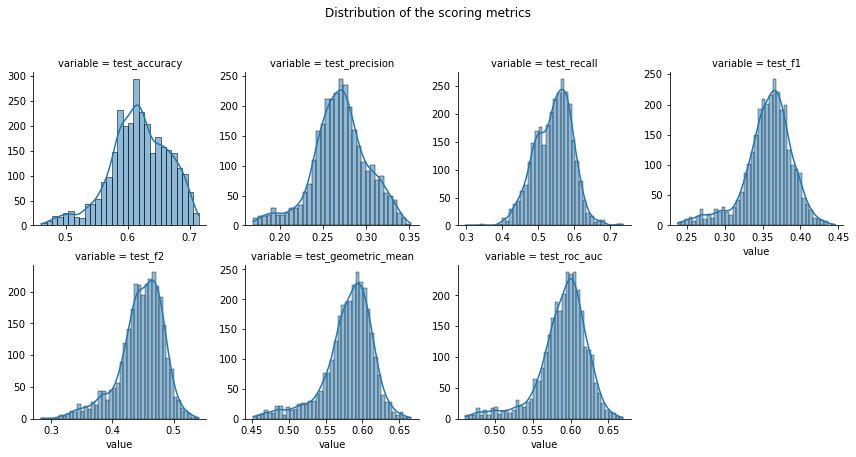

In [4]:
tmp = pd.melt(scores_data, value_vars=scoring_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of the scoring metrics', y=1.05)
plt.savefig('figures/scoring_metrics.png', dpi=128)
plt.show()

<a id='performance'></a>
### Performance of the top classifiers

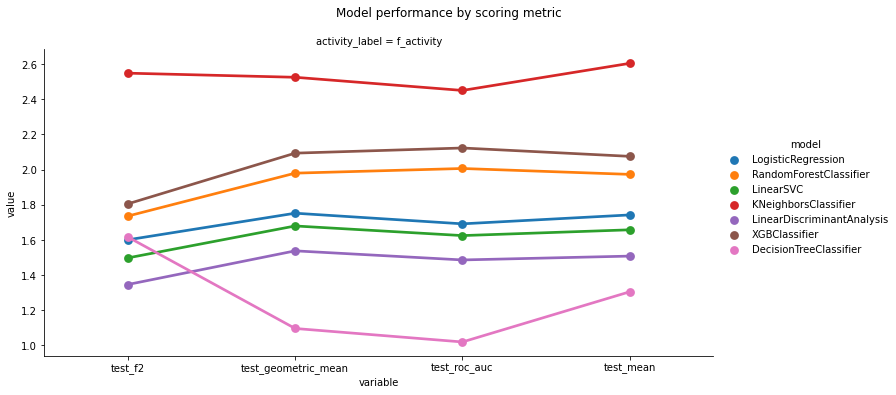

In [5]:
from sklearn.preprocessing import StandardScaler

df = scores_data[['activity_label','model',*test_metrics]].copy()
df[test_metrics] = StandardScaler().fit_transform(df[test_metrics])
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), 
              id_vars=['activity_label','model'], value_vars=test_metrics)
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', 
            hue='model', row='activity_label', aspect=2, order=test_metrics, hue_order=model_list)
plt.suptitle('Model performance by scoring metric', y=1.05)
plt.savefig('figures/test_performance.png', dpi=128)

<a id='finding'></a>
### Finding the best subset

In [6]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}
activity_label = 'f_activity'

for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    model_name = row['model']
    best_subset[model_name] = [descriptor for descriptor in trainset if row[descriptor]]
    print(model_name, best_subset[model_name])

KNeighborsClassifier ['NumHAcceptors', 'TPSA', 'LabuteASA']
XGBClassifier ['NumRotatableBonds', 'TPSA']
RandomForestClassifier ['NumRotatableBonds', 'NumHDonors', 'TPSA', 'LabuteASA', 'plants']
LogisticRegression ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP', 'rfscore_qvina']
LinearSVC ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP', 'rfscore_qvina']
LinearDiscriminantAnalysis ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP', 'rfscore_qvina']
DecisionTreeClassifier ['NumRotatableBonds', 'NumHDonors', 'qvina']


In [7]:
# Most common features
most_common = ['NumRotatableBonds','TPSA','LabuteASA','NumHAcceptors','NumHDonors']

<a id='reconstructing'></a>
## Reconstructing the top models

In [8]:
def get_model_by_name(model_name):
    if model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV is used for applying probability transformation 
        # on top of the SVC outputs, so we can plot the ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    elif model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=40, max_depth=6, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='reg:logistic', n_estimators=40, 
            max_depth=3, eta=0.2, random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        from sklearn.tree import DecisionTreeClassifier
        return DecisionTreeClassifier(max_depth=6, random_state=13)
    elif model_name == 'LinearDiscriminantAnalysis':
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        return LinearDiscriminantAnalysis(solver='svd')
    else:
        return None

In [9]:
def train_test_scores(X_train, X_test, y_train, y_test, model_fitted):
    from sklearn.metrics import fbeta_score
    from imblearn.metrics import geometric_mean_score
    
    scores_list = []
    y_pred_test = model_fitted.predict(X_test)
    y_pred_train = model_fitted.predict(X_train)
    
    scores_list.append(fbeta_score(y_test, y_pred_test, beta=2))       # test_f2
    scores_list.append(fbeta_score(y_train, y_pred_train, beta=2))     # train_f2
    scores_list.append(geometric_mean_score(y_test, y_pred_test))      # test_geometric_mean
    scores_list.append(geometric_mean_score(y_train, y_pred_train))    # train_geometric_mean
    return scores_list

def get_tpr_KFold(X, y, model_fitted, base_fpr):
    from sklearn.metrics import roc_curve
    
    y_proba = model_fitted.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1])
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    return tpr

def plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name):
    from sklearn.metrics import auc
    # Test mean ROC
    tpr_test = np.mean(tpr_test_list, axis=0)
    tpr_test[-1] = 1.0
    test_auc = auc(base_fpr, tpr_test)
    axis[0].plot(base_fpr, tpr_test, label=f'{model_name}: {test_auc:>.3f}')

    # Training mean ROC
    tpr_train = np.mean(tpr_train_list, axis=0)
    tpr_train[-1] = 1.0
    train_auc = auc(base_fpr, tpr_train)
    axis[1].plot(base_fpr, tpr_train, label=f'{model_name}: {train_auc:>.3f}')
    
    return test_auc, train_auc

def get_scores_list_KFold(X, y, pipe, base_fpr):
    from sklearn.model_selection import RepeatedStratifiedKFold
    
    scores_list_KFold = []
    tpr_train_list = []
    tpr_test_list = []
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=5)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        # Test and training scores
        scores_list_KFold.append(train_test_scores(X_train, X_test, y_train, y_test, model_fitted))
        # Test true positive rate
        tpr_test_list.append(get_tpr_KFold(X_test, y_test, model_fitted, base_fpr))
        # Training true positive rate
        tpr_train_list.append(get_tpr_KFold(X_train, y_train, model_fitted, base_fpr))
    
    return scores_list_KFold, tpr_train_list, tpr_test_list
    
def get_mean_scores(X, y, model, model_name, scaler, axis):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    
    base_fpr = np.linspace(0, 1, 101)
    pipe = make_pipeline(SMOTE(random_state=42), scaler, model)
    scores_list_KFold, tpr_train_list, tpr_test_list = get_scores_list_KFold(X, y, pipe, base_fpr)
    
    # All KFold scores for each metric
    df = pd.DataFrame(scores_list_KFold)
    # Mean of the KFold scores by metric
    mean_scores = list(df.mean()) # column-wise
    
    # Plot mean ROC curve
    test_auc, train_auc = plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name)
    # Append mean AUC
    mean_scores.append(test_auc)
    mean_scores.append(train_auc)
    mean_scores.append(model_name)
    return mean_scores

<a id='roc_curves'></a>
### ROC curves

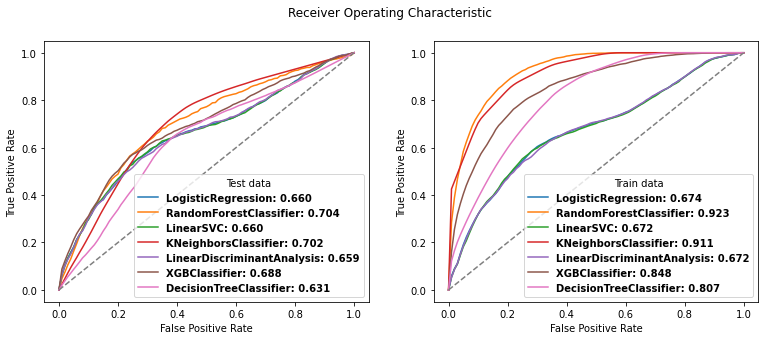

,test_f2,train_f2,test_geometric_mean,train_geometric_mean,test_roc_auc,train_roc_auc,model,test_mean,train_mean
0,0.502549,0.515841,0.634047,0.648199,0.660186,0.673781,LogisticRegression,0.598928,0.612607
1,0.529104,0.771736,0.659609,0.837356,0.703592,0.923084,RandomForestClassifier,0.630768,0.844059
2,0.504052,0.511235,0.637006,0.645831,0.659873,0.672152,LinearSVC,0.600310,0.609740
3,0.540015,0.750466,0.664738,0.822578,0.701945,0.911174,KNeighborsClassifier,0.635566,0.828073
4,0.493211,0.506670,0.626851,0.640956,0.658721,0.672479,LinearDiscriminantAnalysis,0.592928,0.606702
5,0.513688,0.668587,0.649573,0.767197,0.687920,0.847510,XGBClassifier,0.617060,0.761098
6,0.504013,0.637212,0.622294,0.726217,0.630781,0.806692,DecisionTreeClassifier,0.585696,0.723374


In [10]:
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))
# List of scores for the top models
scores_list = []

for model_name in model_list:
    subset = best_subset[model_name]
    y = data[activity_label]
    X = data[subset]
    scaler = StandardScaler()
    model = get_model_by_name(model_name)
    model_scores = get_mean_scores(X, y, model, model_name, scaler, axis=ax)
    scores_list.append(model_scores)

columns = ['test_f2', 'train_f2', 'test_geometric_mean', 'train_geometric_mean', 
           'test_roc_auc', 'train_roc_auc', 'model']
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics[:-1]].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics[:-1]].mean(axis=1)

for i in range(2):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
font_prop = {'weight':'bold'}
ax[0].legend(title='Test data', prop=font_prop)
ax[1].legend(title='Train data', prop=font_prop)

plt.suptitle('Receiver Operating Characteristic')
#plt.savefig('figures/roc_curve_KFold.png', dpi=128)
plt.show()

top_scores

# Demora um pouco para executar
# Explicar melhora 


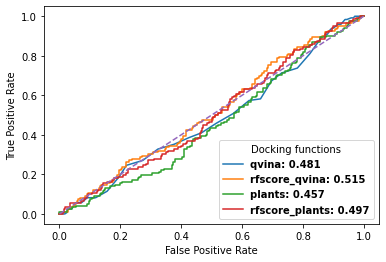

In [19]:
from sklearn.metrics import roc_curve, auc

# Plotting ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    plt.plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')
    
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
font_prop = {'weight':'bold'}
plt.legend(title='Docking functions', loc='lower right', prop=font_prop)
plt.savefig('figures/docking_roc_curve.png', dpi=128)

<a id='supplementary'></a>
## Supplementary data
<a id='comparing'></a>
### Comparing classifiers

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(scores_data.groupby(['model','activity_label']).describe())

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_activity             437.0  0.592012  0.026962   
KNeighborsClassifier       f_activity             437.0  0.637673  0.029447   
LinearDiscriminantAnalysis f_activity             437.0  0.589998  0.040553   
LinearSVC                  f_activity             437.0  0.591669  0.041299   
LogisticRegression         f_activity             437.0  0.594569  0.041530   
RandomForestClassifier     f_activity             437.0  0.656525  0.032143   
XGBClassifier              f_activity             437.0  0.665716  0.032200   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.507862  0.575810  0.596019   
KNeighborsClassifier       f_activity      0.547761  0.619380  0.641305   
LinearDiscriminantAnalysis f_activity      0.460741  0.572621  0.595469   
LinearSVC                  f_activity      0.462195  0.573797  0.596761   
LogisticRegression         f_activity      0.465234  0.578518  0.600419   
RandomForestClassifier     f_activity      0.543013  0.639682  0.660015   
XGBClassifier              f_activity      0.536607  0.650927  0.672471   

                                                              test_precision  \
                                                75%       max          count   
model                      activity_label                                      
DecisionTreeClassifier     f_activity      0.611674  0.652296          437.0   
KNeighborsClassifier       f_activity      0.658786  0.702355          437.0   
LinearDiscriminantAnalysis f_activity      0.616918  0.672226          437.0   
LinearSVC                  f_activity      0.619040  0.676094          437.0   
LogisticRegression         f_activity      0.622286  0.676255          437.0   
RandomForestClassifier     f_activity      0.681678  0.710727          437.0   
XGBClassifier              f_activity      0.689993  0.714370          437.0   

                                                                         \
                                               mean       std       min   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.254655  0.017665  0.198070   
KNeighborsClassifier       f_activity      0.280040  0.029831  0.192722   
LinearDiscriminantAnalysis f_activity      0.256240  0.028035  0.169131   
LinearSVC                  f_activity      0.256842  0.028558  0.169190   
LogisticRegression         f_activity      0.257923  0.029050  0.169303   
RandomForestClassifier     f_activity      0.289498  0.029356  0.193103   
XGBClassifier              f_activity      0.293396  0.029998  0.196624   

                                                                         \
                                                25%       50%       75%   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.244161  0.255402  0.268382   
KNeighborsClassifier       f_activity      0.260545  0.283245  0.301192   
LinearDiscriminantAnalysis f_activity      0.245295  0.260398  0.274263   
LinearSVC                  f_activity      0.245837  0.260920  0.274805   
LogisticRegression         f_activity      0.246525  0.263172  0.276524   
RandomForestClassifier     f_activity      0.272819  0.290537  0.312560   
XGBClassifier              f_activity      0.276521  0.296572  0.316038   

                                                    test_recall            \
                                                max       count      mean   
model                      activity_label  

<a id='top_calssifiers'></a>
### Performance of the top classifiers

Text(0.5, 1.05, 'Model performance by scoring metric')

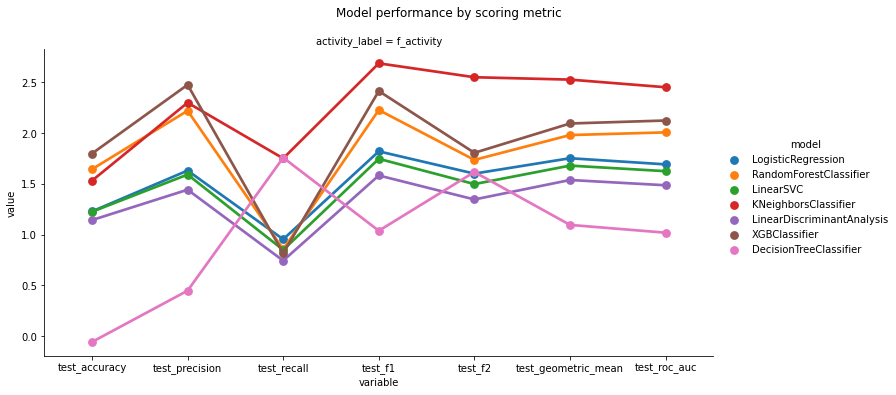

In [14]:
df = scores_data[['activity_label','model',*scoring_metrics]].copy()
df[scoring_metrics] = StandardScaler().fit_transform(df[scoring_metrics])
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), 
              id_vars=['activity_label','model'], value_vars=scoring_metrics)
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', 
            hue='model', row='activity_label', aspect=2, order=scoring_metrics, hue_order=model_list)
plt.suptitle('Model performance by scoring metric', y=1.05)

<a id='docking'></a>
### Docking scores and performance increment

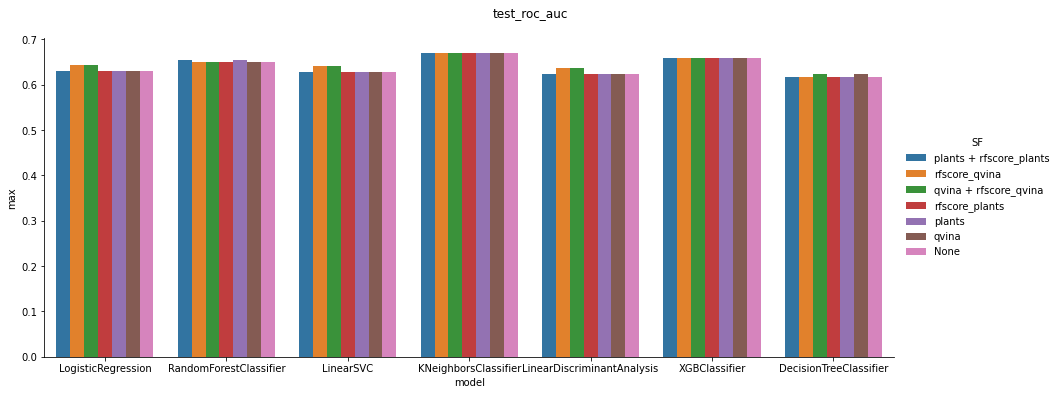

In [15]:
'''
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]
'''

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0'
                      ).groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

sns.catplot(kind='bar', data=df, x='model', y='max', hue='SF', orient='v', aspect=2.5, order=model_list)
plt.suptitle('test_roc_auc', y=1.05)
plt.show()

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.

<a id='top_descriptors'></a>
### Top descriptors

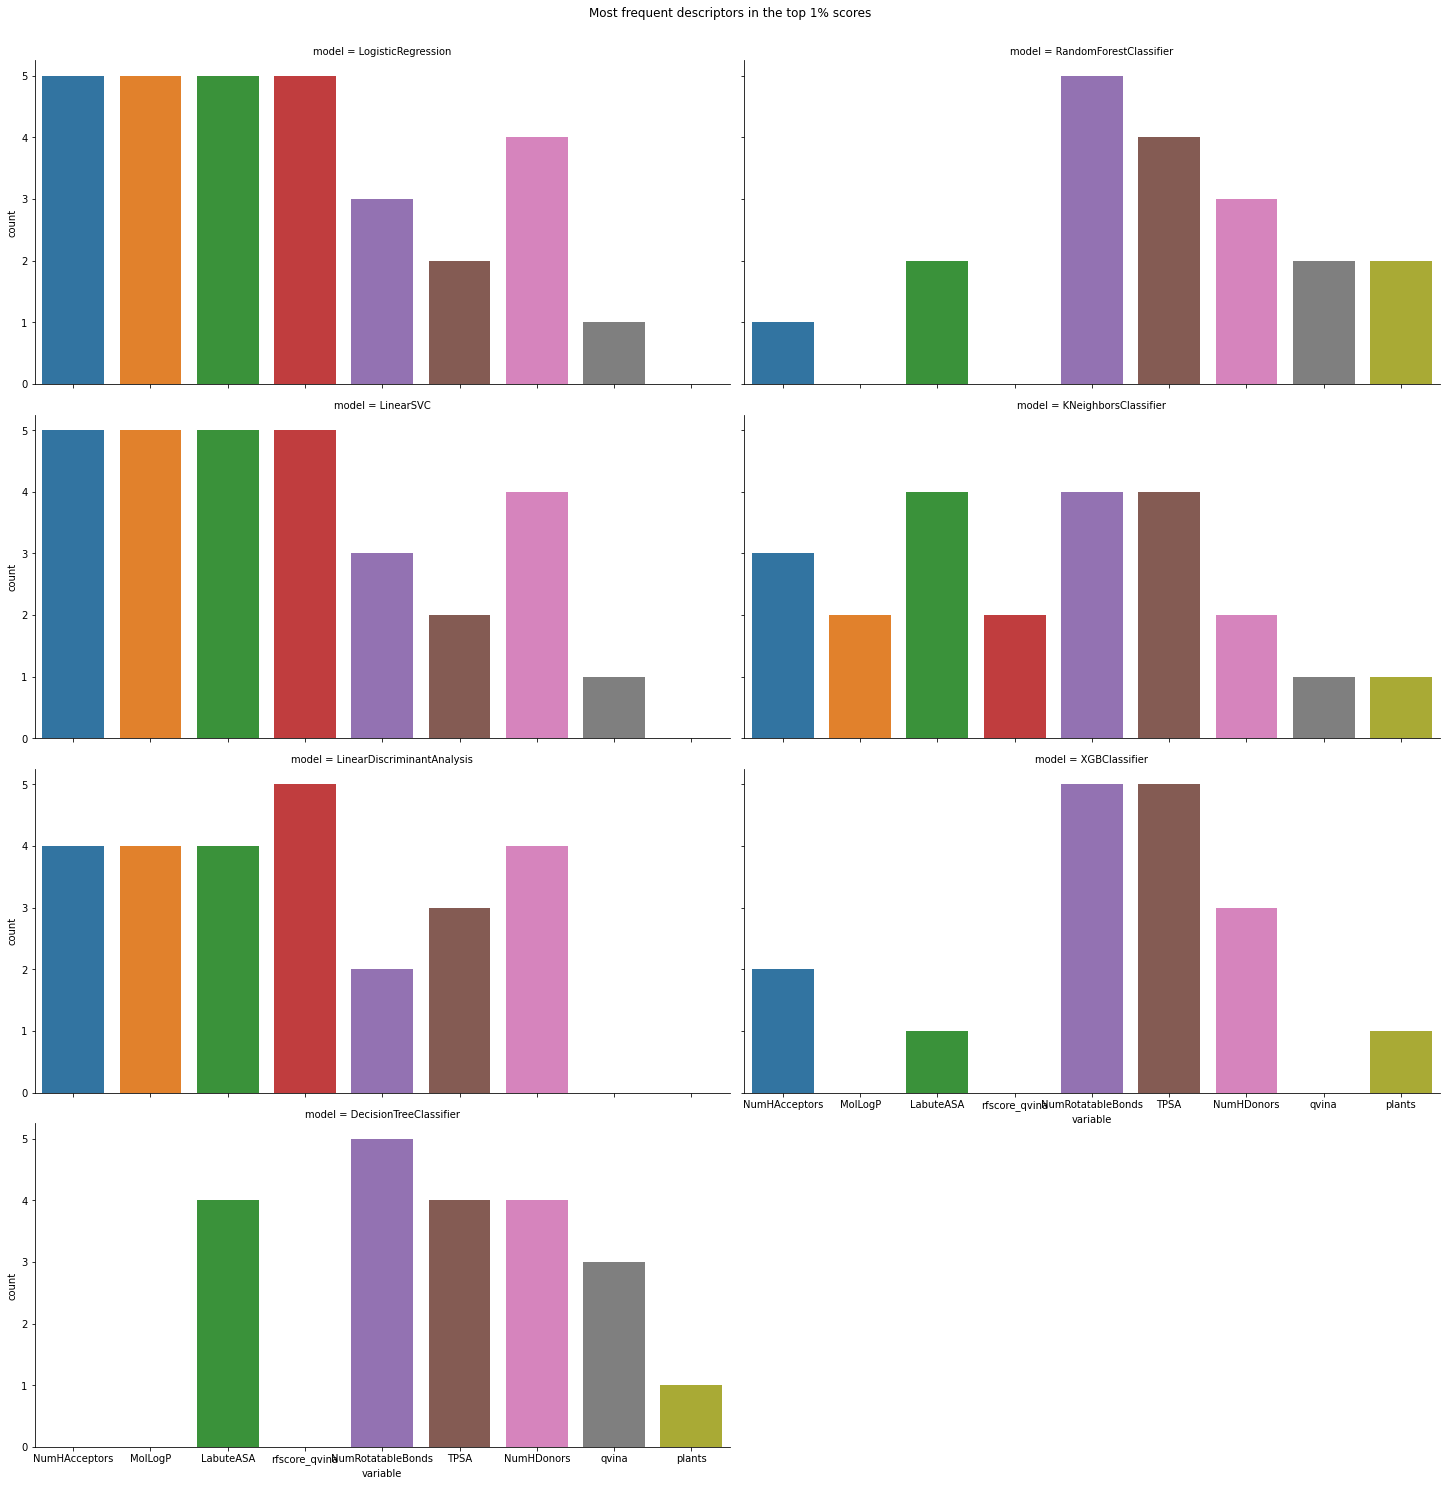

In [16]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=['activity_label','model',*test_metrics], value_vars=trainset, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', 
                col_order=model_list, col_wrap=2, aspect=2)

# Set title
plt.suptitle('Most frequent descriptors in the top 1% scores', y=1.02)
plt.show()

<a id='confusion_matrix'></a>
### Confusion matrix for the best model

In [6]:
def save_pickle(model_fitted, model_name):
    # Serialize model
    import pickle
    import os

    if not os.path.isdir('pickle'):
        os.mkdir('pickle')
    with open(f'pickle/{model_name}.pickle', 'wb') as file:
        pickle.dump(model_fitted, file)

In [12]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

model_name = 'XGBClassifier'
subset = best_subset[model_name]

y = data[activity_label]
X = data[subset]

scaler = StandardScaler()
pipe = make_pipeline(SMOTE(random_state=42), scaler, 
            XGBClassifier(objective='reg:logistic', n_estimators=40, max_depth=3, eta=0.2, random_state=13))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

model_fitted = pipe.fit(X_train, y_train)
save_pickle(model_fitted, model_name)

y_pred = model_fitted.predict(X_test)
y_proba = model_fitted.predict_proba(X_test)[:, 1]

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(model_name)
print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}', end='\n\n')
print(matrix.to_latex(float_format='%.2f'))
matrix

XGBClassifier
RMSE: 0.4412
log_loss: 0.5705

\begin{tabular}{lrr}
\toprule
{} &    0 &    1 \\
\midrule
0 & 0.70 & 0.30 \\
1 & 0.32 & 0.68 \\
\bottomrule
\end{tabular}



,0,1
0,0.70297,0.29703
1,0.32000,0.68000


In [19]:
# Save input data for the serialized model
data.iloc[X_test.index].to_csv('X_test.csv', index=False)

## Para remover posteriormente
<a id='number_of_features'></a>
### Performance according to the number of features

In [20]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier

y = data['f_activity']
X = data[descriptors_list]

# Estimator
model_name = 'XGBClassifier'
estimator = get_model_by_name(model_name)
# Step Forward Feature Selector
StepForward = sfs(estimator, k_features=6, forward=True, floating=False, verbose=2, scoring='accuracy', cv=5)                                   

StepForward.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s finished

[2020-12-12 01:57:16] Features: 1/6 -- score: 0.8051174603174603[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished

[2020-12-12 01:57:17] Features: 2/6 -- score: 0.7955301587301588[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished

[2020-12-12 01:57:17] Features: 3/6 -- score: 0.7827428571428572[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  eta=0.2, gamma=None,
                                                  gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=3,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=

In [21]:
StepForward.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([0.8015873, 0.808    , 0.808    , 0.808    , 0.8      ]),
  'avg_score': 0.8051174603174603,
  'feature_names': ('NumRotatableBonds',)},
 2: {'feature_idx': (0, 2),
  'cv_scores': array([0.79365079, 0.776     , 0.808     , 0.808     , 0.792     ]),
  'avg_score': 0.7955301587301588,
  'feature_names': ('NumRotatableBonds', 'NumHDonors')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([0.78571429, 0.792     , 0.76      , 0.784     , 0.792     ]),
  'avg_score': 0.7827428571428572,
  'feature_names': ('NumRotatableBonds', 'NumHAcceptors', 'NumHDonors')},
 4: {'feature_idx': (0, 1, 2, 4),
  'cv_scores': array([0.79365079, 0.776     , 0.744     , 0.808     , 0.808     ]),
  'avg_score': 0.7859301587301587,
  'feature_names': ('NumRotatableBonds',
   'NumHAcceptors',
   'NumHDonors',
   'LabuteASA')},
 5: {'feature_idx': (0, 1, 2, 4, 5),
  'cv_scores': array([0.8015873, 0.76     , 0.76     , 0.808    , 0.792    ]),
  'avg_score': 0.784317

In [22]:
# Selected feature columns
cols = list(StepForward.k_feature_idx_)
cols

[0, 1, 2, 3, 4, 5]

In [ ]:
features = X.columns[cols]
features

In [ ]:
StepForward.k_feature_names_

In [ ]:
StepForward.k_score_

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

print('best combination (ACC: %.3f): %s\n' % (StepForward.k_score_, StepForward.k_feature_idx_))
print('all subsets:\n', StepForward.subsets_)
plot_sfs(StepForward.get_metric_dict(), kind='std_err');
plt.grid()

In [ ]:
test_data

In [26]:
# Curva ROC para diferentes sementes aleatórias

def train_test_scores(X_train, X_test, y_train, y_test, model_fitted):
    from sklearn.metrics import fbeta_score
    from imblearn.metrics import geometric_mean_score
    
    scores_list = []
    y_pred_test = model_fitted.predict(X_test)
    y_pred_train = model_fitted.predict(X_train)
    
    scores_list.append(fbeta_score(y_test, y_pred_test, beta=2))       # test_f2
    scores_list.append(fbeta_score(y_train, y_pred_train, beta=2))     # train_f2
    scores_list.append(geometric_mean_score(y_test, y_pred_test))      # test_geometric_mean
    scores_list.append(geometric_mean_score(y_train, y_pred_train))    # train_geometric_mean
    return scores_list

def get_tpr_KFold(X, y, model_fitted, base_fpr):
    from sklearn.metrics import roc_curve
    
    y_proba = model_fitted.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1])
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    return tpr

def plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name):
    # Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    from sklearn.metrics import auc
    # Test mean ROC
    tpr_test = np.mean(tpr_test_list, axis=0)
    tpr_test[-1] = 1.0
    test_auc = auc(base_fpr, tpr_test)
    axis[0].plot(base_fpr, tpr_test, label=f'{model_name}: {test_auc:>.3f}')

    # Training mean ROC
    tpr_train = np.mean(tpr_train_list, axis=0)
    tpr_train[-1] = 1.0
    train_auc = auc(base_fpr, tpr_train)
    axis[1].plot(base_fpr, tpr_train, label=f'{model_name}: {train_auc:>.3f}')
    
    return test_auc, train_auc
    
def get_scores_list_KFold(X, y, pipe, base_fpr):
    from sklearn.model_selection import RepeatedStratifiedKFold
    
    scores_list_KFold = []
    tpr_test_list = []
    tpr_train_list = []
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=5)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        # Test and training scores
        scores_list_KFold.append(train_test_scores(X_train, X_test, y_train, y_test, model_fitted))
        # Test true positive rate
        tpr_test_list.append(get_tpr_KFold(X_test, y_test, model_fitted, base_fpr))
        # Training true positive rate
        tpr_train_list.append(get_tpr_KFold(X_train, y_train, model_fitted, base_fpr))
    
    return scores_list_KFold, tpr_test_list, tpr_train_list
    
def get_mean_scores(X, y, model, model_name, scaler, axis):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    
    base_fpr = np.linspace(0, 1, 101)
    scores_list = []
    tpr_test_all = []
    tpr_train_all = []
    
    # Random list generated with np.random.randint()
    seed_list = np.array([40, 15, 72, 22, 43, 82, 75,  7, 34, 49])
    for random_state in seed_list:
        pipe = make_pipeline(SMOTE(random_state=random_state), scaler, model)
        scores_list_KFold, tpr_test_list, tpr_train_list = get_scores_list_KFold(X, y, pipe, base_fpr)
        scores_list.extend(scores_list_KFold)
        tpr_test_all.extend(tpr_test_list)
        tpr_train_all.extend(tpr_train_list)
        
    df = pd.DataFrame(scores_list)
    mean_scores = list(df.mean())
    # Plot mean ROC curve
    test_auc, train_auc = plot_train_test_roc(axis, tpr_test_all, tpr_train_all, base_fpr, model_name)
    # Append mean AUC
    mean_scores.append(test_auc)
    mean_scores.append(train_auc)
    # Append model name
    mean_scores.append(model_name)
    return mean_scores

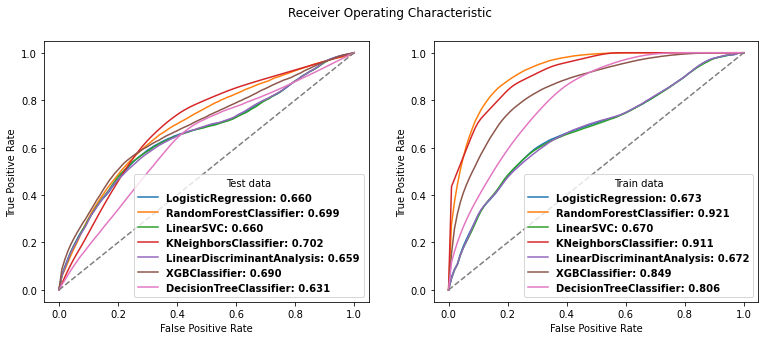

,test_f2,train_f2,test_geometric_mean,train_geometric_mean,test_roc_auc,train_roc_auc,model,test_mean,train_mean
0,0.505477,0.512731,0.639753,0.647987,0.660319,0.672803,LogisticRegression,0.601850,0.611174
1,0.510414,0.770266,0.647387,0.838546,0.699483,0.921079,RandomForestClassifier,0.619095,0.843297
2,0.498946,0.504281,0.637720,0.644053,0.659626,0.670453,LinearSVC,0.598764,0.606263
3,0.540133,0.749010,0.665661,0.821932,0.702306,0.910678,KNeighborsClassifier,0.636033,0.827207
4,0.496183,0.502063,0.632578,0.639623,0.659167,0.671515,LinearDiscriminantAnalysis,0.595976,0.604400
5,0.512956,0.670327,0.651201,0.770583,0.689771,0.848568,XGBClassifier,0.617976,0.763159
6,0.506060,0.640907,0.617782,0.724351,0.630572,0.805906,DecisionTreeClassifier,0.584805,0.723721


In [27]:
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))
# List of scores for the top models
scores_list = []

for model_name in model_list:
    subset = best_subset[model_name]
    y = data[activity_label]
    X = data[subset]
    scaler = StandardScaler()
    model = get_model_by_name(model_name)
    model_scores = get_mean_scores(X, y, model, model_name, scaler, axis=ax)
    scores_list.append(model_scores)

columns = ['test_f2', 'train_f2', 'test_geometric_mean', 'train_geometric_mean', 
           'test_roc_auc', 'train_roc_auc', 'model']
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics[:-1]].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics[:-1]].mean(axis=1)

for i in range(2):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
font_prop = {'weight':'bold'}
ax[0].legend(title='Test data', prop=font_prop)
ax[1].legend(title='Train data', prop=font_prop)

plt.suptitle('Receiver Operating Characteristic')
plt.savefig('figures/roc_curve_KFold.png', dpi=128)
plt.show()

top_scores

# Média das curvas do RepeatedStratifiedKFold
# Demora MUITO tempo para executar (~5-10 min)